In [1]:
import fedhex as fx
from fedhex.pretrain import generation as fxgen
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# List data generation parameters
ndim = 2
sigma = 0.025
ngausx = 5
ngausy = 5
lims = ((0., 1.), (0., 1.))
seed = 0xace1ace1ace1ace1

# Specify generation 'Strategy' for this (gaussian) Generator
# Strategies for gaussian Generators specify the behavior of
# a base covariance matrix that changes over the sample space
strat = fxgen.RepeatStrategy(fxgen.DiagCov(ndim=ndim, sigma=sigma))

In [3]:
# Make a data generator instance for the specified gaussians
ggg = fx.GridGaussGenerator(cov_strat=strat, ngausx=ngausx,
                               ngausy=ngausy, seed=seed, lims=lims)

In [4]:
nsamp = 1000
samples, labels = ggg.generate(nsamp=nsamp)

In [5]:
data, cond = ggg.preproc()

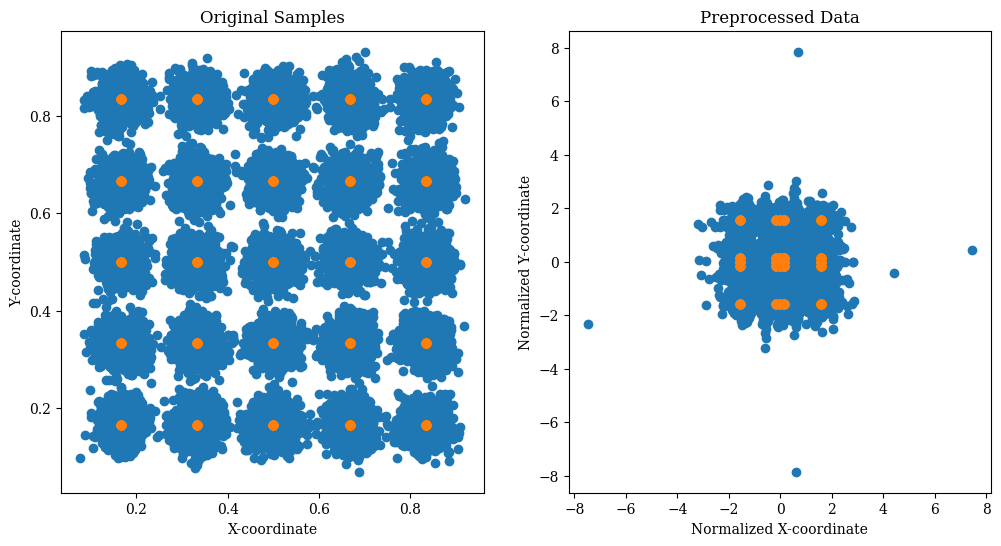

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(samples[:,0], samples[:,1])
ax1.scatter(labels[:,0], labels[:,1])
ax1.set_title("Original Samples")
ax1.set_xlabel("X-coordinate")
ax1.set_ylabel("Y-coordinate")

ax2.scatter(data[:,0], data[:,1])
ax2.scatter(cond[:,0], cond[:,1])
ax2.set_title("Preprocessed Data")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

In [7]:
nmade = 10
ninputs = 2
ncinputs = 2
hidden_layers = 1
hidden_units = 128
lr_tuple = (1e-3, 1e-4, 100)
mm = fx.MADEManager(nmade=nmade, ninputs=ninputs, ncinputs=ncinputs,
                    hidden_layers=hidden_layers, hidden_units=hidden_units,
                    lr_tuple=lr_tuple)

In [8]:
mm.compile_model()

In [9]:
starting_epoch = 0
end_epoch = 200
batch_size = 1024
flow_path = "./model/08-24_tut_root/"
loss_path = flow_path + "loss.npy"

In [10]:
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger

callbacks = []

save_freq = 50 * batch_size
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))

callbacks.append(EpochLossHistory(loss_path=loss_path))

log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

In [11]:
mm.train_model(data=data, cond=cond, batch_size=batch_size,
               starting_epoch=starting_epoch, end_epoch=end_epoch,
               path=flow_path, callbacks=callbacks)

16:20:05.86 <I> [Training begins]


2023-09-15 16:20:05.910706: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


epoch begin: 2023-09-15 16:20:14.854218 | time elapsed: 0:00:08.945237
Epoch 10/200
25/25 [==============================] - 1s 25ms/sample - loss: 5.6906
epoch begin: 2023-09-15 16:20:21.481586 | time elapsed: 0:00:15.572605
Epoch 20/200
25/25 [==============================] - 1s 26ms/sample - loss: 4.1761
epoch begin: 2023-09-15 16:20:28.338835 | time elapsed: 0:00:22.429854
Epoch 30/200
25/25 [==============================] - 1s 31ms/sample - loss: 3.1073
epoch begin: 2023-09-15 16:20:35.943692 | time elapsed: 0:00:30.034711
Epoch 40/200
25/25 [==============================] - 1s 27ms/sample - loss: 2.3122
epoch begin: 2023-09-15 16:20:42.509348 | time elapsed: 0:00:36.600367
Epoch 50/200
25/25 [==============================] - 1s 28ms/sample - loss: 1.6337
epoch begin: 2023-09-15 16:20:49.055832 | time elapsed: 0:00:43.146851
Epoch 60/200
25/25 [==============================] - 1s 27ms/sample - loss: 1.2967
epoch begin: 2023-09-15 16:20:55.648530 | time elapsed: 0:00:49.739549

INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


INFO:tensorflow:Assets written to: ./model/08-24_tut_root/assets


16:22:31.91 <I> [Training ends]
0:02:26.04 <I> [Time elapsed]


In [12]:
ngen = 500
gen_labels_unique = [0.5, 0.5]
gen_labels = np.repeat([gen_labels_unique], ngen, axis=0)
gen_cond = ggg.norm(gen_labels, is_cond=True)

In [13]:
gen_data = mm.eval_model(gen_cond)

In [14]:
gen_samples = ggg.denorm(gen_data, is_cond=False)

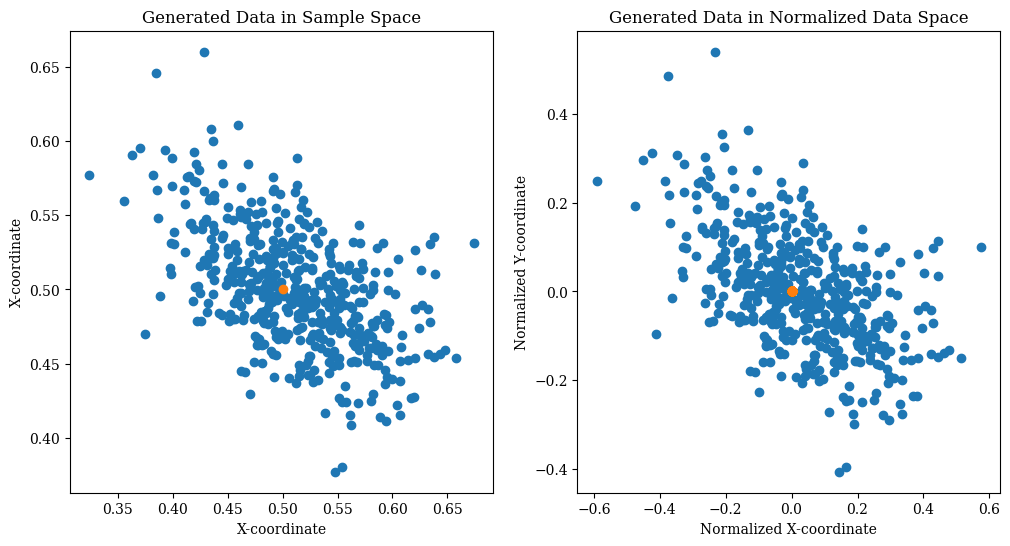

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.scatter(gen_samples[:,0], gen_samples[:,1])
ax1.scatter(gen_labels_unique[0], gen_labels_unique[1])
ax1.set_title("Generated Data in Sample Space")
ax1.set_xlabel("X-coordinate")
ax1.set_ylabel("X-coordinate")

ax2.scatter(gen_data[:,0], gen_data[:,1])
ax2.scatter(gen_cond[:,0], gen_cond[:,1])
ax2.set_title("Generated Data in Normalized Data Space")
ax2.set_xlabel("Normalized X-coordinate")
ax2.set_ylabel("Normalized Y-coordinate")
pass

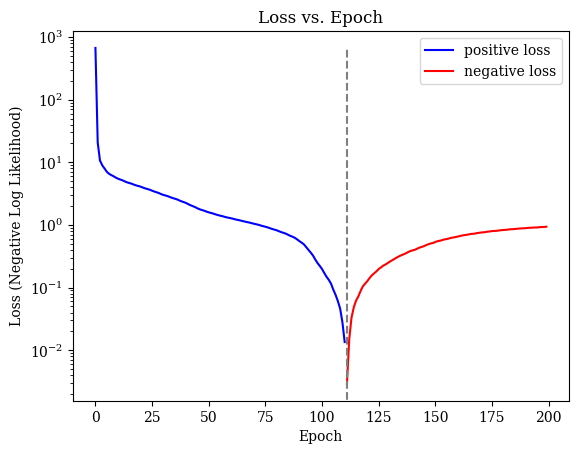

In [16]:
from fedhex.posttrain import plot as fxp
fxp.plot_losses(np.load(loss_path), show=True)

In [17]:
#Save output to a ROOT or npy file. Training data ("trn_data", "trn_cond") is optional
output_path = "./output/09-15-tut_gauss/"
npy_path = output_path + "npy/npy_out_gauss.npy"
root_out_path = output_path + "root/root_out_gauss.ROOT"
custom_root_path = output_path + "root/custom_root_out_gauss.ROOT"
#All directories above must already exist

saver = fx.Loader(data_dict={"gen_samples": gen_samples, "gen_labels": gen_labels, "trn_samples": samples, "trn_labels": labels})

saver.save_to_root(root_out_path, custom=False) #Requires above dictionary format

fx.Loader(data_dict = 
          {"Gen_X": gen_samples[:,0], "Gen_Y" : gen_samples[:,1], "Gen_X_Labels":gen_labels[:,0], "Gen_Y_Labels":gen_labels[:,1]}
          ).save_to_root(custom_root_path, custom=True) #Default mode, dictionary can be of any format as long as all values are of equal length

saver.save_to_npy(npy_path)